# Training & Testing Menggunakan Market-1501

Link Dataset

Market-1501
https://zheng-lab.cecs.anu.edu.au/Project/project_reid.html


# Training

### Data

In [ ]:
import os
import math
import copy
import shutil

import pandas as pd
import numpy as np

import time

from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torchvision
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights, resnet50, ResNet50_Weights, resnext50_32x4d, ResNeXt50_32X4D_Weights
from torch.cuda.amp import GradScaler, autocast
from torchsummary import summary
from torch.autograd import Variable

# import skimage
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score

In [ ]:
dataset_path = "/content/Market-1501-v15.09.15/"
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/Semester 6/Deep/Proyek/Dataset/Market-1501-v15.09.15.zip'

# Directory to extract the contents of the zip file
extracted_dir_path = '/content/'

# Create a directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Zip file has been extracted successfully.")

extracted_files = os.listdir(extracted_dir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Zip file has been extracted successfully.


In [ ]:
import os
from shutil import copyfile

download_path = '/content/Market-1501-v15.09.15'

if not os.path.isdir(download_path):
    print('please change the download_path')

save_path = download_path + '/pytorch'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
#-----------------------------------------
#query
query_path = download_path + '/query'
query_save_path = download_path + '/pytorch/query'
if not os.path.isdir(query_save_path):
    os.mkdir(query_save_path)

for root, dirs, files in os.walk(query_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')

        if ID[0] == '-1':
          continue

        src_path = query_path + '/' + name
        dst_path = query_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#-----------------------------------------
#multi-query
query_path = download_path + '/gt_bbox'

if os.path.isdir(query_path):
    query_save_path = download_path + '/pytorch/multi-query'
    if not os.path.isdir(query_save_path):
        os.mkdir(query_save_path)

    for root, dirs, files in os.walk(query_path, topdown=True):
        for name in files:
            if not name[-3:]=='jpg':
                continue
            ID  = name.split('_')
            src_path = query_path + '/' + name
            dst_path = query_save_path + '/' + ID[0]
            if not os.path.isdir(dst_path):
                os.mkdir(dst_path)
            copyfile(src_path, dst_path + '/' + name)

#-----------------------------------------
#gallery
gallery_path = download_path + '/bounding_box_test'
gallery_save_path = download_path + '/pytorch/gallery'
if not os.path.isdir(gallery_save_path):
    os.mkdir(gallery_save_path)

for root, dirs, files in os.walk(gallery_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')

        if ID[0] == '-1':
          continue

        src_path = gallery_path + '/' + name
        dst_path = gallery_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#---------------------------------------
#train_all
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train_all'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)


#---------------------------------------
#train_val
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train'
val_save_path = download_path + '/pytorch/val'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)
    os.mkdir(val_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
            dst_path = val_save_path + '/' + ID[0]
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

In [ ]:
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/train")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/val")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/gallery")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/query")))

751
751
751
750


In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

def move_files(src_path, dst_path, split_percentage):
    if not os.path.isdir(dst_path):
        os.makedirs(dst_path)

    class_folders = os.listdir(src_path)
    num_classes = len(class_folders)

    num_train_classes = int(num_classes * split_percentage)
    train_classes = class_folders[:num_train_classes]

    for class_folder in train_classes:
        if class_folder == '-1':
            continue
        src_class_path = os.path.join(src_path, class_folder)
        dst_class_path = os.path.join(dst_path, class_folder)
        shutil.move(src_class_path, dst_class_path)

        src_image_path = os.path.join(dst_class_path, os.listdir(dst_class_path)[0])
        dst_val_class_path = os.path.join(val_save_path, class_folder)
        if not os.path.exists(dst_val_class_path):
            os.makedirs(dst_val_class_path)
        shutil.move(src_image_path, dst_val_class_path)

In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

def filter_query(src_path, reference_classes):
    query_folders = os.listdir(src_path)
    for query_folder in query_folders:
        if query_folder not in reference_classes:
            shutil.rmtree(os.path.join(src_path, query_folder))

In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

gallery_path = '/content/Market-1501-v15.09.15/pytorch/gallery'
query_path = '/content/Market-1501-v15.09.15/pytorch/query'

split_percentage = 0.6

move_files(gallery_path, train_save_path, split_percentage)

print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/train")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/val")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/gallery")))

1201
1201
301


In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

reference_classes = os.listdir(gallery_path)
filter_query(query_path, reference_classes)
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/query")))

301


In [ ]:
h, w = 256, 128
data_dir = '/content/Market-1501-v15.09.15/pytorch'
batchsize = 64
num_epochs = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
transform_train_list = [
    transforms.Resize((h, w), interpolation=3),
    transforms.Pad(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

transform_val_list = [
    transforms.Resize(size=(h, w), interpolation=3),  # Image.BICUBIC
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

data_transforms = {
    'train': transforms.Compose(transform_train_list),
    'val': transforms.Compose(transform_val_list),
}

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                               data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                             data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=True, num_workers=2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(len(class_names))

1201


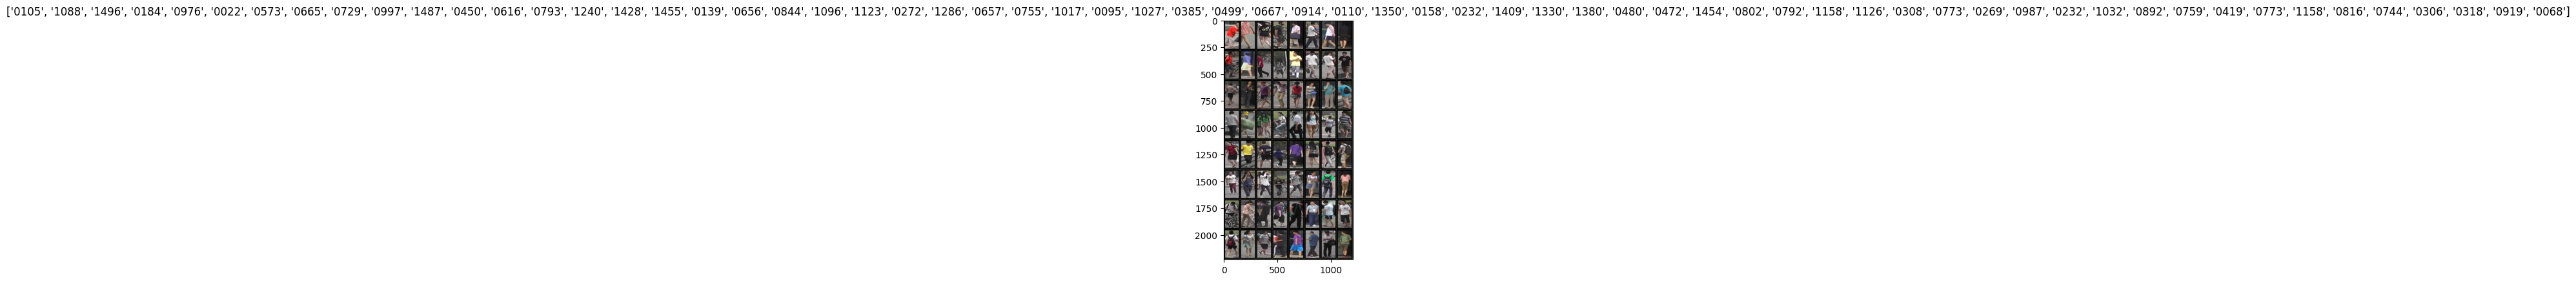

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, save_dir, save_train_name, save_best_name, num_epochs=25, start_epoch=0,):
    since = time.time()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_train = os.path.join(save_dir, save_train_name)
    save_best = os.path.join(save_dir, save_best_name)

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        scaler = GradScaler()

        if start_epoch > 0:
          if os.path.exists(save_best):
            model.load_state_dict(torch.load(save_best))
          else:
            model.load_state_dict(torch.load(save_train))
          print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                torch.save(model.state_dict(), save_train)

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), save_best)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def train_model_no_gs(model, dataloaders, criterion, optimizer, scheduler, save_dir, save_train_name, save_best_name, num_epochs=25, start_epoch=0,):
    since = time.time()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_train = os.path.join(save_dir, save_train_name)
    save_best = os.path.join(save_dir, save_best_name)

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        if start_epoch > 0:
          if os.path.exists(save_best):
            model.load_state_dict(torch.load(save_best))
          else:
            model.load_state_dict(torch.load(save_train))
          print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                torch.save(model.state_dict(), save_train)

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), save_best)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ResNet18

In [ ]:
modelResnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet18.fc.in_features
modelResnet18.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18.to(device)

modelResnet18.eval()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.AdamW(modelResnet18.parameters(), lr=0.001)
optimizer_ft = optim.AdamW(modelResnet18_gs.parameters(), lr=2e-4, weight_decay=0.015)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
save_dir = '/content/drive/My Drive/Proyek_deep/Proyek/Model/'
save_train = 'train_resnet18_market-1501.pt'
save_best = 'best_param_resnet18_market-1501.pt'

modelResnet18_gs = train_model(modelResnet18, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 4.0418 Acc: 0.2316
val Loss: 4.5930 Acc: 0.1082

Epoch 1/29
----------
train Loss: 1.8277 Acc: 0.5440
val Loss: 2.3402 Acc: 0.4097

Epoch 2/29
----------
train Loss: 0.8537 Acc: 0.7723
val Loss: 1.9816 Acc: 0.5046

Epoch 3/29
----------
train Loss: 0.4338 Acc: 0.8857
val Loss: 1.7092 Acc: 0.5695

Epoch 4/29
----------
train Loss: 0.2496 Acc: 0.9346
val Loss: 1.5282 Acc: 0.6178

Epoch 5/29
----------
train Loss: 0.1663 Acc: 0.9554
val Loss: 1.4965 Acc: 0.6120

Epoch 6/29
----------
train Loss: 0.1027 Acc: 0.9753
val Loss: 1.1857 Acc: 0.6928

Epoch 7/29
----------
train Loss: 0.0280 Acc: 0.9968
val Loss: 0.8020 Acc: 0.7802

Epoch 8/29
----------
train Loss: 0.0112 Acc: 0.9999
val Loss: 0.7634 Acc: 0.7827

Epoch 9/29
----------
train Loss: 0.0087 Acc: 0.9999
val Loss: 0.7216 Acc: 0.7985

Epoch 10/29
----------
train Loss: 0.0069 Acc: 1.0000
val Loss: 0.7048 Acc: 0.8052

Epoch 11/29
----------
train Loss: 0.0058 Acc: 1.0000
val Loss: 0.6906 Acc: 0.8102

Epoch 12/29
----------
t

In [ ]:
# File for checkpoints
save_dir = '/content/drive/My Drive/Proyek_deep/Proyek/Model/'
save_train = 'train_resnet18_market-1501_no_gs.pt'
save_best = 'best_param_resnet18_market-1501_no_gs.pt'

modelResnet18_nogs = train_model_no_gs(modelResnet18, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 5.9615 Acc: 0.1291
val Loss: 5.9967 Acc: 0.0258

Epoch 1/29
----------
train Loss: 3.1112 Acc: 0.3370
val Loss: 3.7138 Acc: 0.2098

Epoch 2/29
----------
train Loss: 1.3312 Acc: 0.6576
val Loss: 1.9783 Acc: 0.4838

Epoch 3/29
----------
train Loss: 0.6629 Acc: 0.8213
val Loss: 1.7956 Acc: 0.5237

Epoch 4/29
----------
train Loss: 0.3409 Acc: 0.9100
val Loss: 1.5963 Acc: 0.5953

Epoch 5/29
----------
train Loss: 0.1909 Acc: 0.9516
val Loss: 1.2680 Acc: 0.6619

Epoch 6/29
----------
train Loss: 0.1236 Acc: 0.9701
val Loss: 1.4930 Acc: 0.6586

Epoch 7/29
----------
train Loss: 0.0426 Acc: 0.9928
val Loss: 0.7940 Acc: 0.7893

Epoch 8/29
----------
train Loss: 0.0148 Acc: 0.9997
val Loss: 0.7490 Acc: 0.8093

Epoch 9/29
----------
train Loss: 0.0110 Acc: 0.9998
val Loss: 0.7115 Acc: 0.8160

Epoch 10/29
----------
train Loss: 0.0088 Acc: 1.0000
val Loss: 0.7057 Acc: 0.8127

Epoch 11/29
----------
train Loss: 0.0076 Acc: 1.0000
val Loss: 0.6883 Acc: 0.8185

Ep

In [ ]:
visualize_model(modelResnet18)

### ResNet34

In [ ]:
modelResnet34 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet34.fc.in_features
modelResnet34.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34.to(device)

modelResnet34.eval()

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.AdamW(modelResnet34.parameters(), lr=0.001)
optimizer_ft = optim.AdamW(modelResnet18_gs.parameters(), lr=2e-4, weight_decay=0.015)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
save_dir = '/content/drive/My Drive/Proyek_deep/Proyek/Model/'
save_train = 'train_resnet34_market-1501.pt'
save_best = 'best_param_resnet34_market-1501.pt'

modelResnet34_gs = train_model(modelResnet34, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 6.2835 Acc: 0.1240
val Loss: 7.0443 Acc: 0.0025

Epoch 1/29
----------
train Loss: 4.3111 Acc: 0.1937
val Loss: 4.3883 Acc: 0.1174

Epoch 2/29
----------
train Loss: 2.2963 Acc: 0.4403
val Loss: 3.9101 Acc: 0.2323

Epoch 3/29
----------
train Loss: 1.2515 Acc: 0.6614
val Loss: 2.8800 Acc: 0.3672

Epoch 4/29
----------
train Loss: 0.7249 Acc: 0.7955
val Loss: 2.2779 Acc: 0.4713

Epoch 5/29
----------
train Loss: 0.4293 Acc: 0.8768
val Loss: 1.6667 Acc: 0.5970

Epoch 6/29
----------
train Loss: 0.2767 Acc: 0.9208
val Loss: 1.5473 Acc: 0.6378

Epoch 7/29
----------
train Loss: 0.0940 Acc: 0.9794
val Loss: 0.9236 Acc: 0.7610

Epoch 8/29
----------
train Loss: 0.0416 Acc: 0.9950
val Loss: 0.8633 Acc: 0.7727

Epoch 9/29
----------
train Loss: 0.0295 Acc: 0.9977
val Loss: 0.8131 Acc: 0.7902

Epoch 10/29
----------
train Loss: 0.0232 Acc: 0.9986
val Loss: 0.8118 Acc: 0.7985

Epoch 11/29
----------
train Loss: 0.0184 Acc: 0.9994
val Loss: 0.8110 Acc: 0.7985

Epoch 12/29
----------
t

In [ ]:
# File for checkpoints
save_dir = '/content/drive/My Drive/Proyek_deep/Proyek/Model/'
save_train = 'train_resnet34_market-1501_no_gs.pt'
save_best = 'best_param_resnet34_market-1501_no_gs.pt'

modelResnet34_nogs = train_model_no_gs(modelResnet34, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.3543 Acc: 0.1226
val Loss: 7.3694 Acc: 0.0042

Epoch 1/29
----------
train Loss: 4.8731 Acc: 0.1608
val Loss: 4.9081 Acc: 0.0699

Epoch 2/29
----------
train Loss: 2.6941 Acc: 0.3703
val Loss: 3.7396 Acc: 0.2148

Epoch 3/29
----------
train Loss: 1.4739 Acc: 0.6054
val Loss: 2.2482 Acc: 0.4346

Epoch 4/29
----------
train Loss: 0.8440 Acc: 0.7661
val Loss: 1.9806 Acc: 0.4996

Epoch 5/29
----------
train Loss: 0.5234 Acc: 0.8482
val Loss: 1.6349 Acc: 0.5828

Epoch 6/29
----------
train Loss: 0.3383 Acc: 0.9018
val Loss: 1.6086 Acc: 0.6037

Epoch 7/29
----------
train Loss: 0.1084 Acc: 0.9761
val Loss: 0.8816 Acc: 0.7585

Epoch 8/29
----------
train Loss: 0.0552 Acc: 0.9928
val Loss: 0.8530 Acc: 0.7660

Epoch 9/29
----------
train Loss: 0.0405 Acc: 0.9964
val Loss: 0.8075 Acc: 0.7860

Epoch 10/29
----------
train Loss: 0.0333 Acc: 0.9976
val Loss: 0.8055 Acc: 0.7902

Epoch 11/29
----------
train Loss: 0.0258 Acc: 0.9988
val Loss: 0.7779 Acc: 0.7927

Ep

In [ ]:
visualize_model(modelResnet34)

### ResNet50

In [ ]:
modelResnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet50.fc.in_features
modelResnet50.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50.to(device)

modelResnet50.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.AdamW(modelResnet18_gs.parameters(), lr=0.001)
optimizer_ft = optim.AdamW(modelResnet18_gs.parameters(), lr=2e-4, weight_decay=0.015)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
modelResnet50 = train_model(modelResnet50, dataloaders, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

In [ ]:
visualize_model(modelResnet50)

### ResNext50_32x4d

In [ ]:
modelResnext = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

num_ftrs = modelResnext.fc.in_features
modelResnext.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext.to(device)

modelResnext.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.AdamW(modelResnext.parameters(), lr=0.001)
optimizer_ft = optim.AdamW(modelResnet18_gs.parameters(), lr=2e-4, weight_decay=0.015)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 135MB/s]


In [ ]:
# File for checkpoints
save_dir = '/content/drive/My Drive/Semester 6/Deep/Proyek/Model/'
save_train = 'train_resnext_market1501.pt'
save_best = 'best_param_resnext_market1501.pt'

modelResnext_gs = train_model(modelResnext, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/0
----------
train Loss: 6.4431 Acc: 0.0194
val Loss: 6.6005 Acc: 0.0146

Training complete in 143m 30s
Best val Acc: 0.014647


In [ ]:
# File for checkpoints
save_dir = '/content/drive/My Drive/Semester 6/Deep/Proyek/Model/'
save_train = 'train_resnext_market-1501_no_gs.pt'
save_best = 'best_param_resnext_market-1501_no_gs.pt'

modelResnext_nogs = train_model_no_gs(modelResnext, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.5028 Acc: 0.0088
val Loss: 6.4351 Acc: 0.0053

Epoch 1/29
----------
train Loss: 5.4733 Acc: 0.0344
val Loss: 5.6590 Acc: 0.0200

Epoch 2/29
----------
train Loss: 4.1296 Acc: 0.1405
val Loss: 4.6072 Acc: 0.1225

Epoch 3/29
----------
train Loss: 2.8005 Acc: 0.3246
val Loss: 3.9838 Acc: 0.1838

Epoch 4/29
----------
train Loss: 1.8905 Acc: 0.4939
val Loss: 3.1372 Acc: 0.3009

Epoch 5/29
----------
train Loss: 1.2498 Acc: 0.6511
val Loss: 2.3939 Acc: 0.4487

Epoch 6/29
----------
train Loss: 0.8436 Acc: 0.7565
val Loss: 2.1991 Acc: 0.5073

Epoch 7/29
----------
train Loss: 0.3411 Acc: 0.9156
val Loss: 1.3237 Acc: 0.6751

Epoch 8/29
----------
train Loss: 0.2062 Acc: 0.9608
val Loss: 1.1665 Acc: 0.7190

Epoch 9/29
----------
train Loss: 0.1600 Acc: 0.9745
val Loss: 1.1744 Acc: 0.7190

Epoch 10/29
----------
train Loss: 0.1338 Acc: 0.9791
val Loss: 1.1635 Acc: 0.7244

Epoch 11/29
----------
train Loss: 0.1078 Acc: 0.9869
val Loss: 1.1395 Acc: 0.7164

Ep

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


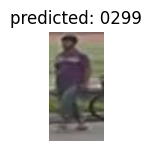

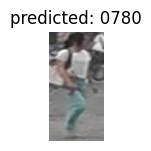

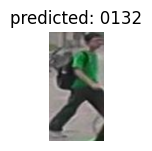

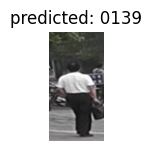

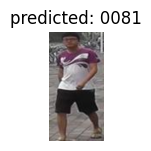

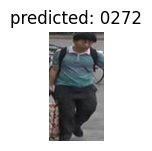

In [ ]:
visualize_model(modelResnext)

# Testing

### Prepare

In [ ]:
transform_test_list = [
    transforms.Resize(size=(h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

data_transforms = {
    'gallery': transforms.Compose(transform_test_list),
    'query': transforms.Compose(transform_test_list),
}

image_datasets = {}
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(data_dir, 'gallery'),
                                               data_transforms['gallery'])
image_datasets['query'] = datasets.ImageFolder(os.path.join(data_dir, 'query'),
                                             data_transforms['query'])

dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=True, num_workers=2, pin_memory=True)
               for x in ['gallery', 'query']}

dataset_test_sizes = {x: len(image_datasets[x]) for x in ['gallery', 'query']}
test_class_names = image_datasets['gallery'].classes
print(len(test_class_names))

301


In [ ]:
def process_in_batches(loader, model, device, batch_size=32):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            batch_features = []
            batch_labels = []
            for i in range(0, len(imgs), batch_size):
                batch_imgs = imgs[i:i+batch_size]
                batch_lbls = lbls[i:i+batch_size]
                batch_outputs = model(batch_imgs)
                batch_features.append(batch_outputs.cpu().numpy())
                batch_labels.append(batch_lbls.cpu().numpy())
            features.append(np.concatenate(batch_features))
            labels.append(np.concatenate(batch_labels))
    return np.concatenate(features), np.concatenate(labels)

In [ ]:
def compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams, max_rank=10):
  num_q, num_g = dist_matrix.shape

  indices = np.argsort(dist_matrix, axis=1)
  all_cmc = []
  all_AP = []
  all_INP = []
  num_valid_q = 0

  gallery_labels = np.array(gallery_labels)
  gallery_cams = np.array(gallery_cams)

  for q_idx in range(num_q):
    q_pid = query_labels[q_idx]
    q_camid = query_cams[q_idx]

    order = indices[q_idx]
    remove = (gallery_labels[order] == q_pid) & (gallery_cams[order] == q_camid)
    keep = np.invert(remove)

    matches = (gallery_labels[order] == q_pid).astype(np.int32)
    raw_cmc = matches[keep]
    if not np.any(raw_cmc):
      continue

    cmc = raw_cmc.cumsum()

    pos_idx = np.where(raw_cmc == 1)[0]
    max_pos_idx = np.max(pos_idx)

    cmc[cmc > 1] = 1

    all_cmc.append(cmc[:max_rank])
    num_valid_q += 1.

    num_rel = raw_cmc.sum()
    tmp_cmc = raw_cmc.cumsum()
    tmp_cmc = [x / (i + 1.) for i, x in enumerate(tmp_cmc)]
    tmp_cmc = np.asarray(tmp_cmc) * raw_cmc
    AP = tmp_cmc.sum() / num_rel
    all_AP.append(AP)

  assert num_valid_q > 0, 'Error: all query identities do not appear in gallery'

  all_cmc = np.asarray(all_cmc).astype(np.float32)
  all_cmc = all_cmc.sum(0) / num_valid_q

  mAP = np.mean(all_AP)

  return mAP, all_cmc

In [ ]:
def compute_distance_matrix(query_features, gallery_features, batch_size=32):
    num_query = query_features.shape[0]
    num_gallery = gallery_features.shape[0]
    dist_matrix = np.zeros((num_query, num_gallery))

    for i in range(0, num_query, batch_size):
        query_batch = query_features[i:i+batch_size]
        for j in range(0, num_gallery, batch_size):
            gallery_batch = gallery_features[j:j+batch_size]
            query_gallery_dist = np.linalg.norm(query_batch[:, np.newaxis] - gallery_batch, axis=2)
            dist_matrix[i:i+len(query_batch), j:j+len(gallery_batch)] = query_gallery_dist

    return dist_matrix

In [ ]:
def predict(dist_matrix, gallery_class_names):
    predictions = []
    for dist in dist_matrix:
        pred_idx = np.argmin(dist)
        predictions.append(gallery_class_names[pred_idx])
    return predictions

### ResNet18

In [ ]:
modelResnet18_gs = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet18_gs.fc.in_features
modelResnet18_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18_gs.to(device)
modelResnet18_gs.eval()

modelResnet18_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/fine-tuned/best_param_resnet18_market-1501.pt', map_location=device))
modelResnet18_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet18_gs.state_dict():
    modelResnet18_gs.state_dict()[param_tensor] = modelResnet18_gs.state_dict()[param_tensor].to(device)
modelResnet18_gs.fc.weight.data = modelResnet18_gs.fc.weight.data.to(device)
modelResnet18_gs.fc.bias.data = modelResnet18_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet18_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet18_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [int(image_datasets['query'].imgs[i][0].split('_')[1][1]) for i in range(len(query_labels))]
gallery_cams = [int(image_datasets['gallery'].imgs[i][0].split('_')[1][1]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

In [ ]:
mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.4693
mAP: 0.7892
CMC (top-1, top-5, top-10): 0.9807, 0.9933, 0.9940


In [ ]:
modelResnet18_no_gs = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet18_no_gs.fc.in_features
modelResnet18_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18_no_gs.to(device)
modelResnet18_no_gs.eval()

modelResnet18_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/fine-tuned/best_param_resnet18_market-1501_no_gs.pt', map_location=device))
modelResnet18_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet18_no_gs.state_dict():
    modelResnet18_no_gs.state_dict()[param_tensor] = modelResnet18_no_gs.state_dict()[param_tensor].to(device)
modelResnet18_no_gs.fc.weight.data = modelResnet18_no_gs.fc.weight.data.to(device)
modelResnet18_no_gs.fc.bias.data = modelResnet18_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet18_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet18_no_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [int(image_datasets['query'].imgs[i][0].split('_')[1][1]) for i in range(len(query_labels))]
gallery_cams = [int(image_datasets['gallery'].imgs[i][0].split('_')[1][1]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.4725
mAP: 0.7834
CMC (top-1, top-5, top-10): 0.9821, 0.9918, 0.9955


### ResNet34

In [ ]:
modelResnet34_gs = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet34_gs.fc.in_features
modelResnet34_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34_gs.to(device)
modelResnet34_gs.eval()

modelResnet34_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/fine-tuned/best_param_resnet34_market-1501.pt', map_location=device))
modelResnet34_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet34_gs.state_dict():
    modelResnet34_gs.state_dict()[param_tensor] = modelResnet34_gs.state_dict()[param_tensor].to(device)
modelResnet34_gs.fc.weight.data = modelResnet34_gs.fc.weight.data.to(device)
modelResnet34_gs.fc.bias.data = modelResnet34_gs.fc.bias.data.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 47.1MB/s]


In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet34_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet34_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [int(image_datasets['query'].imgs[i][0].split('_')[1][1]) for i in range(len(query_labels))]
gallery_cams = [int(image_datasets['gallery'].imgs[i][0].split('_')[1][1]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.6362
mAP: 0.8651
CMC (top-1, top-5, top-10): 0.9881, 0.9963, 0.9985


In [ ]:
modelResnet34_no_gs = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet34_no_gs.fc.in_features
modelResnet34_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34_no_gs.to(device)
modelResnet34_no_gs.eval()

modelResnet34_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/2/best_param_resnet34_market-1501_no_gs.pt', map_location=device))
modelResnet34_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet34_no_gs.state_dict():
    modelResnet34_no_gs.state_dict()[param_tensor] = modelResnet34_no_gs.state_dict()[param_tensor].to(device)
modelResnet34_no_gs.fc.weight.data = modelResnet34_no_gs.fc.weight.data.to(device)
modelResnet34_no_gs.fc.bias.data = modelResnet34_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet34_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet34_no_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [int(image_datasets['query'].imgs[i][0].split('_')[1][1]) for i in range(len(query_labels))]
gallery_cams = [int(image_datasets['gallery'].imgs[i][0].split('_')[1][1]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.3848
mAP: 0.7521
CMC (top-1, top-5, top-10): 0.9598, 0.9821, 0.9896


### ResNet50

In [ ]:
modelResnet50_gs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet50_gs.fc.in_features
modelResnet50_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50_gs.to(device)
modelResnet50_gs.eval()

modelResnet50_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/4/best_param_resnet50_market-1501.pt', map_location=device))
modelResnet50_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet50_gs.state_dict():
    modelResnet50_gs.state_dict()[param_tensor] = modelResnet50_gs.state_dict()[param_tensor].to(device)
modelResnet50_gs.fc.weight.data = modelResnet50_gs.fc.weight.data.to(device)
modelResnet50_gs.fc.bias.data = modelResnet50_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet50_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet50_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [int(image_datasets['query'].imgs[i][0].split('_')[1][1]) for i in range(len(query_labels))]
gallery_cams = [int(image_datasets['gallery'].imgs[i][0].split('_')[1][1]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.2029
mAP: 0.5983
CMC (top-1, top-5, top-10): 0.9449, 0.9792, 0.9859


In [ ]:
modelResnet50_no_gs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet50_no_gs.fc.in_features
modelResnet50_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50_no_gs.to(device)
modelResnet50_no_gs.eval()

modelResnet50_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/2/best_param_resnet50_market-1501_no_gs.pt', map_location=device))
modelResnet50_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet50_no_gs.state_dict():
    modelResnet50_no_gs.state_dict()[param_tensor] = modelResnet50_no_gs.state_dict()[param_tensor].to(device)
modelResnet50_no_gs.fc.weight.data = modelResnet50_no_gs.fc.weight.data.to(device)
modelResnet50_no_gs.fc.bias.data = modelResnet50_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet50_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet50_no_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [int(image_datasets['query'].imgs[i][0].split('_')[1][1]) for i in range(len(query_labels))]
gallery_cams = [int(image_datasets['gallery'].imgs[i][0].split('_')[1][1]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.2001
mAP: 0.5981
CMC (top-1, top-5, top-10): 0.9509, 0.9799, 0.9896


### ResNext50_32x4d

In [ ]:
modelResnext_gs = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
num_ftrs = modelResnext_gs.fc.in_features
modelResnext_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext_gs.eval()
modelResnext_gs.to(device)

modelResnext_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/2/best_param_resnext_market-1501.pt', map_location=device))
modelResnext_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnext_gs.state_dict():
    modelResnext_gs.state_dict()[param_tensor] = modelResnext_gs.state_dict()[param_tensor].to(device)
modelResnext_gs.fc.weight.data = modelResnext_gs.fc.weight.data.to(device)
modelResnext_gs.fc.bias.data = modelResnext_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnext_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnext_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [int(image_datasets['query'].imgs[i][0].split('_')[1][1]) for i in range(len(query_labels))]
gallery_cams = [int(image_datasets['gallery'].imgs[i][0].split('_')[1][1]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.2724
mAP: 0.6544
CMC (top-1, top-5, top-10): 0.9360, 0.9784, 0.9859


In [ ]:
modelResnext_no_gs = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
num_ftrs = modelResnext_no_gs.fc.in_features
modelResnext_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext_no_gs.eval()
modelResnext_no_gs.to(device)

modelResnext_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/2/best_param_resnext_market-1501_no_gs.pt', map_location=device))
modelResnext_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnext_no_gs.state_dict():
    modelResnext_no_gs.state_dict()[param_tensor] = modelResnext_no_gs.state_dict()[param_tensor].to(device)
modelResnext_no_gs.fc.weight.data = modelResnext_no_gs.fc.weight.data.to(device)
modelResnext_no_gs.fc.bias.data = modelResnext_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnext_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnext_no_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [int(image_datasets['query'].imgs[i][0].split('_')[1][1]) for i in range(len(query_labels))]
gallery_cams = [int(image_datasets['gallery'].imgs[i][0].split('_')[1][1]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.3393
mAP: 0.7156
CMC (top-1, top-5, top-10): 0.9665, 0.9874, 0.9918
